# Classification using 'video list'

In [ ]:
#default_exp nb_08

In [ ]:
#export
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *
from kgl_deepfake.nb_03 import *

### Data

In [ ]:
SOURCE = Path('data/dfdc_train_part_0')

In [ ]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
1,vpmyeepbep.mp4,REAL,train,NaN
2,fzvpbrzssi.mp4,REAL,train,NaN
3,htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
4,fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


#### Get face detector

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
detector = MTCNN(device=device, post_process=False)

#### Remove videos in which no faces are detected.  

In [ ]:
fnames = [SOURCE/o for o in annots.fname]

In [ ]:
hasface = get_has_face(fnames, detector)

In [ ]:
annots_hasface = annots[np.array(hasface)]

#### Create `DataBunch`

In [ ]:
VAL = Path('../../data/train_sample_videos/')

In [ ]:
f_val = get_files(VAL, extensions=['.json'])[0]
annots_val = pd.read_json(f_val).T
annots_val.reset_index(inplace=True)
annots_val.rename({'index':'fname'}, axis=1, inplace=True)
annots_val.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [ ]:
fnames_val = [VAL/o for o in annots_val.fname]

In [ ]:
hasface_val = get_has_face(fnames_val, detector)

In [ ]:
annots_hasface_val = annots_val[np.array(hasface_val)]

In [ ]:
src_train = (VideoFaceList
       .from_df(df=annots_hasface, path=SOURCE, cols='fname', detector=detector))

In [ ]:
src_val = (VideoFaceList
       .from_df(df=annots_hasface_val, path=VAL, cols='fname', detector=detector))

In [ ]:
src = src_train.split_by_list(train=src_train, valid=src_val)

In [ ]:
src

ItemLists;

Train: VideoFaceList (1334 items)
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: data/dfdc_train_part_0;

Valid: VideoFaceList (400 items)
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
Path: ../../data/train_sample_videos;

Test: None

In [ ]:
bs, sz = 64, 128

In [ ]:
%%time
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, device=device, num_workers=0).normalize())

CPU times: user 1min 27s, sys: 902 ms, total: 1min 28s
Wall time: 25.3 s


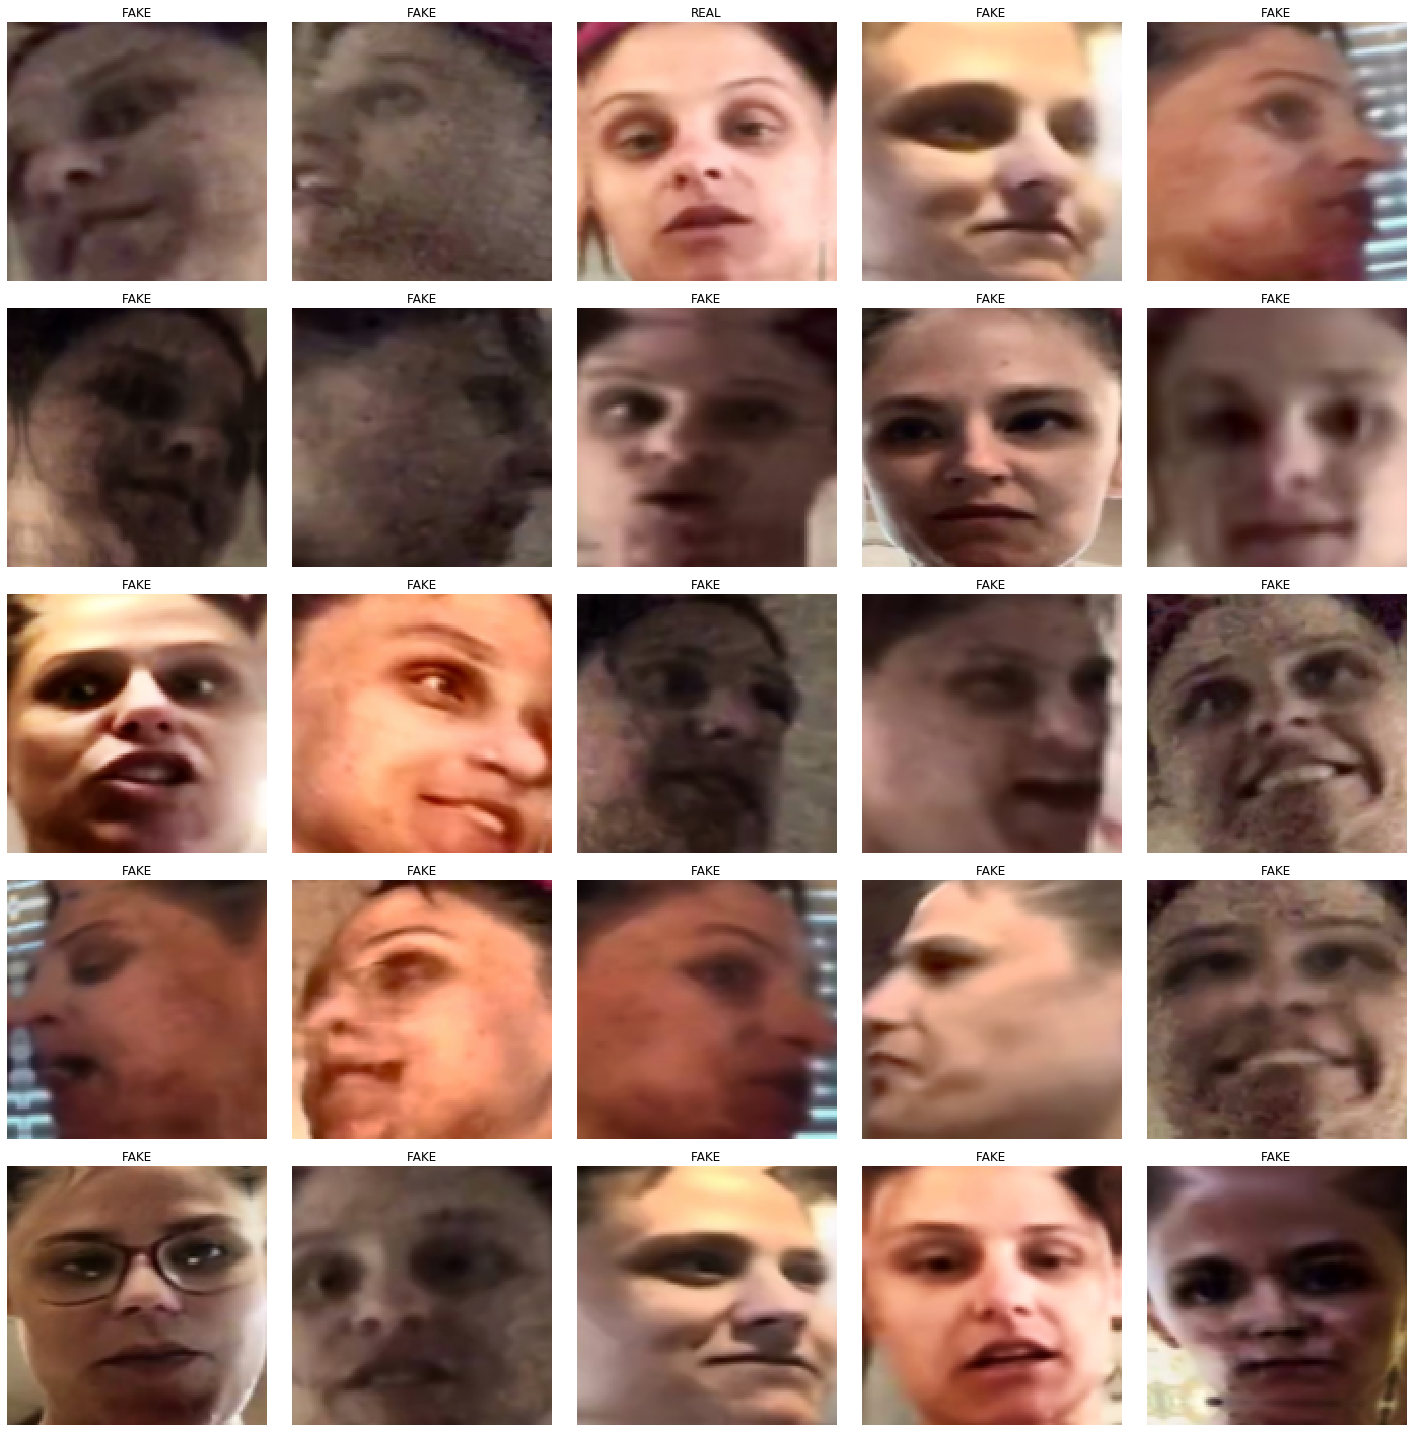

In [ ]:
data.show_batch()

### Model

In [ ]:
model = MesoNet()

### Learner

In [ ]:
learn = Learner(data, model, metrics=accuracy)

### Train

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(cyc_len=1, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.421642,0.563918,0.807500,05:22


In [ ]:
x, y = data.one_batch()

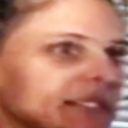

In [ ]:
Image(x[0])

In [ ]:
learn.predict(Image(x[0]))

(Category FAKE, tensor(0), tensor([0.9116, 0.0884]))

In [ ]:
learn.predict(Image(x[0]))

(Category FAKE, tensor(0), tensor([0.9040, 0.0960]))

Try with the PyTorch model

In [ ]:
model = learn.model

In [ ]:
model.eval();

In [ ]:
model(x[0][None].cuda())

tensor([[ 0.7322, -0.5290]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
model(x[0][None].cuda())

tensor([[ 1.8992, -0.7357]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
learn.save('mesonet_over')

In [ ]:
learn.load('mesonet_stage1');

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fc7d05135f8>>
Traceback (most recent call last):
  File "/space/storage/homes/nathan/Babar/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/space/storage/homes/nathan/Babar/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/space/tools/python/python_3.6.5/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/space/tools/python/python_3.6.5/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/space/tools/python/python_3.6.5/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [ ]:
learn.export('mesonet_stage1.pkl')

### Results

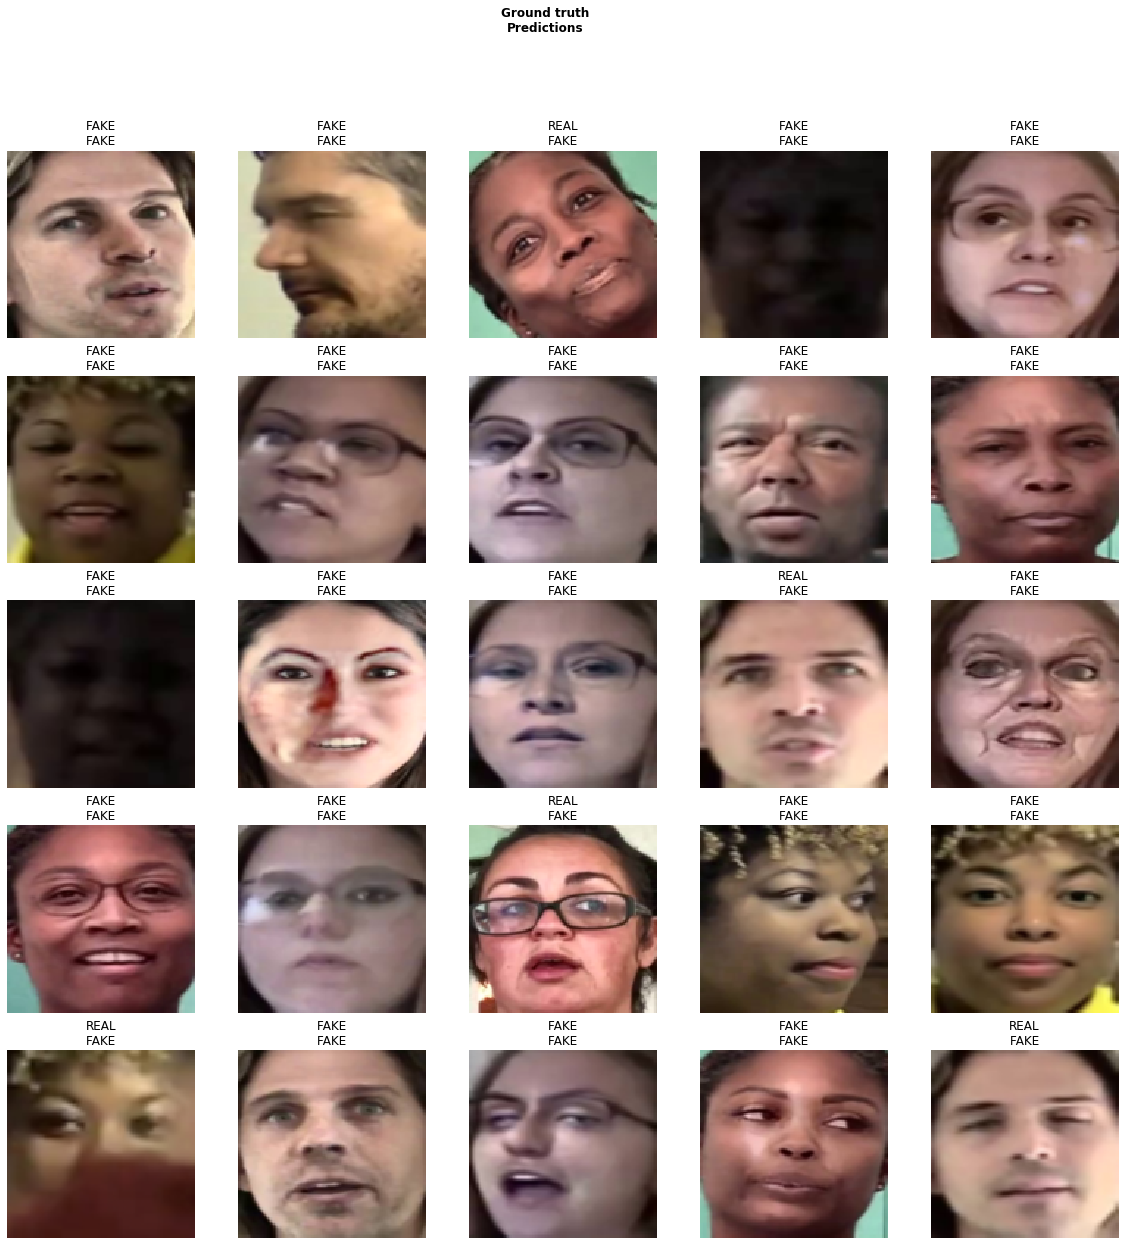

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

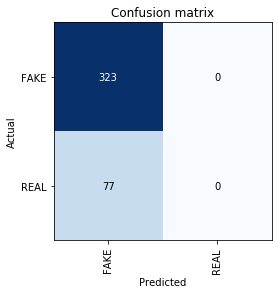

In [ ]:
interp.plot_confusion_matrix()

### Inference

In [ ]:
SOURCE_TEST = Path('data/test_videos/')

In [ ]:
fnames = get_files(SOURCE_TEST, extensions=['.mp4'])
fnames[:3]

[PosixPath('data/test_videos/lnhkjhyhvw.mp4'),
 PosixPath('data/test_videos/swsaoktwgi.mp4'),
 PosixPath('data/test_videos/fopjiyxiqd.mp4')]

Again, because we can't deal with videos which have no detected face, we need to ignore them for now.

In [ ]:
hasface_tst = get_has_face(fnames, detector)

In [ ]:
fnames_tst_hasface = [f for f, b in zip(fnames, hasface_tst) if b]
len(fnames_tst_hasface)

400

In [ ]:
vlist = VideoFaceList(sorted(fnames_tst_hasface), detector=detector)

In [ ]:
learn = load_learner(path='../data', file='mesonet_stage1.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '../data/mesonet_stage1.pkl'

Note that there are 400 test videos, but we will only be able to write an entry in the submission file for 396 of these.

In [ ]:
! head  ../data/sample_submission.csv

In [ ]:
learn.data.classes # this is the opposite for Kaggle scoring

['FAKE', 'REAL']

In [ ]:
cats = learn.data.classes[:]

In [ ]:
#export
def infer_on_videolist(learn:Learner, vlist:VideoFaceList):
    filenames, labels = [], []
    for i in progress_bar(range(len(vlist))):
        fn, img = vlist.items[i], vlist[i]
        _, _, y = learn.predict(img)
        filenames.append(fn.name)
        labels.append(float(y[0]))
    return pd.DataFrame({'filename':filenames, 'label':labels})

In [ ]:
df = infer_on_videolist(learn, vlist)

In [ ]:
df.head()

,filename,label
0,aassnaulhq.mp4,0.859038
1,aayfryxljh.mp4,0.571859
2,acazlolrpz.mp4,0.673427
3,adohdulfwb.mp4,0.987528
4,ahjnxtiamx.mp4,0.807736


In [ ]:
df = infer_on_videolist(learn, vlist)

In [ ]:
df.head()

,filename,label
0,aassnaulhq.mp4,0.905823
1,aayfryxljh.mp4,0.937395
2,acazlolrpz.mp4,0.715075
3,adohdulfwb.mp4,0.941511
4,ahjnxtiamx.mp4,0.916851


In [ ]:
df.to_csv('submission.csv', index=False)

In [ ]:
! head submission.csv

filename,label
aassnaulhq.mp4,0
aayfryxljh.mp4,0
acazlolrpz.mp4,0
adohdulfwb.mp4,0
ahjnxtiamx.mp4,0
ajiyrjfyzp.mp4,0
aktnlyqpah.mp4,0
alrtntfxtd.mp4,0
aomqqjipcp.mp4,1


# - fin

In [ ]:
from nbdev.export import *
notebook2script()